# Running tests

**Global imports**

In [1]:
import lightem
from itertools import combinations, chain
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import *

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Compute metrics and histogram functions**

In [2]:
def generate_pairs(clusters):
    pairs = set()
    for cluster in clusters:
        cluster = list(set(cluster))  # remove duplicatas
        for a, b in combinations(cluster, 2):
            pairs.add(tuple(sorted((a, b))))
    return pairs

def compute_metrics(gt_clusters, pred_clusters, all_ids=None):
    gt_pairs = generate_pairs(gt_clusters)
    pred_pairs = generate_pairs(pred_clusters)

    TP = len(gt_pairs & pred_pairs)
    FP = len(pred_pairs - gt_pairs)
    FN = len(gt_pairs - pred_pairs)

    # Define universo de entidades
    if all_ids is None:
        all_ids = set()
        for c in gt_clusters + pred_clusters:
            all_ids.update(c)
        all_ids = list(all_ids)

    total_pairs = len(all_ids) * (len(all_ids) - 1) // 2
    TN = total_pairs - TP - FP - FN

    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall = TP / (TP + FN) if TP + FN > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (TP + TN) / total_pairs if total_pairs > 0 else 0.0

    metrics = {
        'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy
    }

    metrics_log10 = {}
    for k, v in metrics.items():
      if isinstance(v, (int, float)) and v > 0:
        metrics_log10[k] = math.log10(v)
      else:
        metrics_log10[k] = float('-inf') if isinstance(v, (int, float)) else v
      metrics_log10[k] = round(metrics_log10[k], 3)
    
    matrix = np.array([
        [metrics_log10['TP'], metrics_log10['FP']],
        [metrics_log10['FN'], metrics_log10['TN']]
    ])

    # Labels personalizados combinando nome + valor
    labels = np.array([
        [f"TP\n{metrics['TP']}", f"FP\n{metrics['FP']}"],
        [f"FN\n{metrics['FN']}", f"TN\n{metrics['TN']}"]
    ])

    plt.figure(figsize=(6, 5))

    matrix = np.log10(matrix + 1e-10)  # Adiciona uma pequena constante para evitar log(0)
    
    sns.heatmap(matrix, annot=labels, fmt='', cmap="Blues", cbar=False, square=True,
                xticklabels=["Positive", "Negative"],
                yticklabels=["Positive", "Negative"])
    plt.title("Confusion Matrix (Log10 Scale)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    # Retorna como um DataFrame (tabela)
    return pd.DataFrame([metrics])

def index_to_cluster_map(clusters):
  index_map = {}
  for i, cluster in enumerate(clusters):
      for idx in cluster:
          index_map[idx] = set(cluster)
  return index_map
  
def b3_metrics(gt_clusters, pred_clusters):
  gt_map = index_to_cluster_map(gt_clusters)
  pred_map = index_to_cluster_map(pred_clusters)
  all_indices = set(gt_map.keys()) | set(pred_map.keys())

  precisions = []
  recalls = []

  for idx in all_indices:
    gt_cluster = gt_map.get(idx, {idx})
    pred_cluster = pred_map.get(idx, {idx})
    intersection = gt_cluster & pred_cluster

    if len(pred_cluster) > 0:
        precisions.append(len(intersection) / len(pred_cluster))
    else:
      precisions.append(0)

    if len(gt_cluster) > 0:
      recalls.append(len(intersection) / len(gt_cluster))
    else:
        recalls.append(0)

  precision = sum(precisions) / len(precisions)
  recall = sum(recalls) / len(recalls)
  f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

  return {
      "precision": precision,
      "recall": recall,
      "f1_score": f1
  }
  
def generate_pairwise_links(clusters):
  """Gera todos os pares (a, b) tal que a e b estão no mesmo cluster"""
  pairs = set()
  for cluster in clusters:
    unique = list(set(cluster))  # remove duplicatas
    for a, b in combinations(unique, 2):
      pairs.add(tuple(sorted((a, b))))
  return pairs

def pairwise_metrics(gt_clusters, pred_clusters):
  gt_pairs = generate_pairwise_links(gt_clusters)
  pred_pairs = generate_pairwise_links(pred_clusters)

  TP = len(gt_pairs & pred_pairs)
  FP = len(pred_pairs - gt_pairs)
  FN = len(gt_pairs - pred_pairs)

  precision = TP / (TP + FP) if TP + FP else 0
  recall = TP / (TP + FN) if TP + FN else 0
  f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

  return {
    "TP": TP,
    "FP": FP,
    "FN": FN,
    "precision": precision,
    "recall": recall,
    "f1_score": f1
  }

def get_ground_truth(databasePath):
  gt_fileName = databasePath + '/ground_truth.txt'
  clusters = []
  with open(gt_fileName, 'r') as f:
    lines = f.readlines()
    for line in lines:
      nums = line.strip().split(',')
      nums = tuple(int(num) for num in nums)
      clusters.append(nums)
  return clusters

# faz um histograma de quantidade de tamanho de clusters
def histogram(clusters):
  hist = defaultdict(int)
  for cluster in clusters:
    hist[len(cluster)] += 1
  return hist

def print_histogram(hist):
  for k, v in hist.items():
    print(f'{k}: {v}')
  print('total:', sum(hist.values()))
  
def plot_histogram(hist, title, figsize=(10, 6)):
  plt.figure(figsize=figsize)
  bars = plt.bar(hist.keys(), hist.values(), color='blue', alpha=0.7)

  # Adiciona o valor acima de cada barra
  for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
                str(int(height)), ha='center', va='bottom', fontsize=10)

  plt.xlabel('Cluster Size')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.xticks(list(hist.keys()))
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()

In [3]:
# MULTIEM evaluation
from dataclasses import dataclass
@dataclass
class Metric:
  p: Optional[float] = None
  r: Optional[float] = None
  f1: Optional[float] = None

  def log(self, prefix=None):
    print(f"{f'[{prefix}] ' if prefix else ''}P={self.p:.4f}, R={self.r:.4f}, F1={self.f1:.4f}")
        
        
def evaluate_log(ground_truth: List[Tuple], prediction: List[Tuple]):
  prediction = [tuple(sorted(pred)) for pred in prediction]
  ground_truth = [tuple(sorted(gt)) for gt in ground_truth]
  metric, pair_metric = evaluate(ground_truth, prediction)
  metric.log(prefix="none")
  pair_metric.log(prefix="pair")
  
def evaluate(ground_truth: List[Tuple], prediction: List[Tuple]) -> Tuple[Metric, Metric]:
  print(f"num of ground truth: {len(ground_truth)}")
  print(f"num of prediction: {len(prediction)}")
  f1_metric = evaluate_f1(ground_truth, prediction)
  pair_f1_metric = evaluate_pair_f1(ground_truth, prediction)
  return f1_metric, pair_f1_metric

def evaluate_f1(ground_truth: List[Tuple], prediction: List[Tuple]) -> Metric:
  ground_truth = set(ground_truth)
  prediction = set(prediction)
  truth = len(ground_truth.intersection(prediction))
  P = truth / len(prediction)
  R = truth / len(ground_truth)
  F1 = 2 * P * R / (P + R)
  return Metric(p=P, r=R, f1=F1)

def evaluate_pair_f1(ground_truth: List[Tuple], prediction: List[Tuple]) -> Metric:
    ground_truth_pairs = tuple_2_pairs(ground_truth)
    prediction_pairs = tuple_2_pairs(prediction)
    return evaluate_f1(ground_truth_pairs, prediction_pairs)
  
def tuple_2_pairs(tuples: List[Tuple]) -> List[Tuple]:
    return list(chain(*[combinations(tup, 2) for tup in tuples]))

## Geo

**Global Variables**:

In [4]:
# global variables for Geo run
columns = {
  'name': 1,
  # 'longtitude': 1,
  # 'latitude': 1,
}
databasePath = './data/Geo'
geoGroundTruth = get_ground_truth(databasePath)

### Glove

In [5]:
start = time.time()
gloveGeoEm = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, matcherType='knn', threshold=0.75, gloveModelPath='./bin/glove.6B.300d.bin', minLenghtToSubCluster=0, filterOversizedClusters=5)
gloveGeoEm.configureKnn(1)
gloveGeoClusters = gloveGeoEm.pipeline()
end = time.time()
print('GloVe Geo run time:', end - start, 'seconds')

[07:40:31.31000]: Starting pipeline...
[07:40:31.31000]: Single table created with 3054 rows.
[07:40:31.31000]: Text column created.
[07:40:33.33000]: Embeddings created.
[07:40:33.33000]: Pairs created.
[07:40:33.33000]: Graph created. Creating clusters...
[07:40:34.34000]: Clusters created.
GloVe Geo run time: 3.858259916305542 seconds


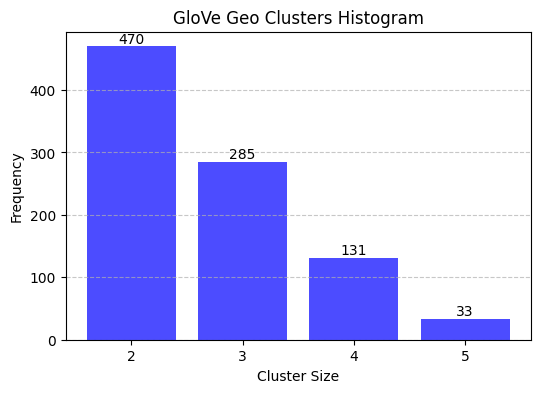

In [6]:
plot_histogram(histogram(gloveGeoClusters), 'GloVe Geo Clusters Histogram', figsize=(6, 4))

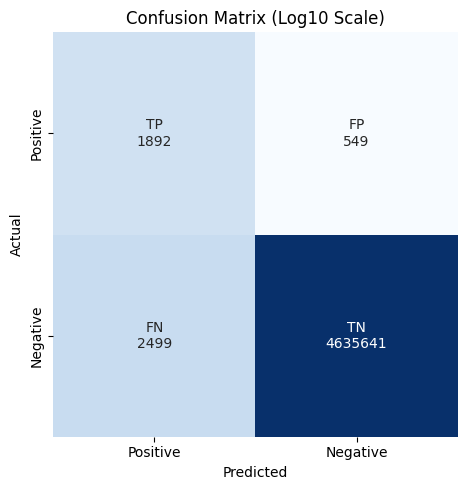

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,1892,549,2499,4635641,0.775092,0.430881,0.553864,0.999343


In [7]:
compute_metrics(geoGroundTruth, gloveGeoClusters)

In [8]:
b3_metrics(geoGroundTruth, gloveGeoClusters)

{'precision': 0.8945520183787331,
 'recall': 0.5858768187288045,
 'f1_score': 0.7080344256724216}

In [9]:
pairwise_metrics(geoGroundTruth, gloveGeoClusters)

{'TP': 1892,
 'FP': 549,
 'FN': 2499,
 'precision': 0.7750921753379763,
 'recall': 0.4308813482122523,
 'f1_score': 0.5538641686182669}

In [10]:
evaluate_log(geoGroundTruth, gloveGeoClusters)

num of ground truth: 786
num of prediction: 919
[none] P=0.1425, R=0.1667, F1=0.1537
[pair] P=0.7751, R=0.4309, F1=0.5539


In [11]:
del gloveGeoEm

### Sentence Bert - CPU

In [12]:
start = time.time()
bertGeoEm = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cpu', matcherType='knn', threshold=0.75, minLenghtToSubCluster=0, filterOversizedClusters=5)
bertGeoEm.configureKnn(1)
bertGeoClusters = bertGeoEm.pipeline()
end = time.time()
print('Sentence-Bert Geo run time:', end - start, 'seconds')

[07:40:34.34000]: Starting pipeline...
[07:40:34.34000]: Single table created with 3054 rows.
[07:40:34.34000]: Text column created.
Using device: cuda:0
[07:41:10.10000]: Embeddings created.
[07:41:10.10000]: Pairs created.
[07:41:10.10000]: Graph created. Creating clusters...
[07:41:11.11000]: Clusters created.
Sentence-Bert Geo run time: 36.26418423652649 seconds


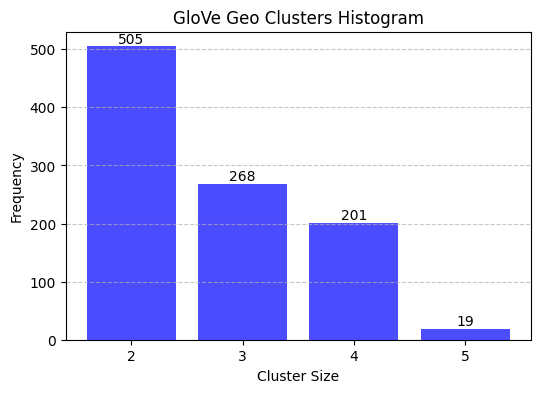

In [13]:
plot_histogram(histogram(bertGeoClusters), 'GloVe Geo Clusters Histogram', figsize=(6, 4))

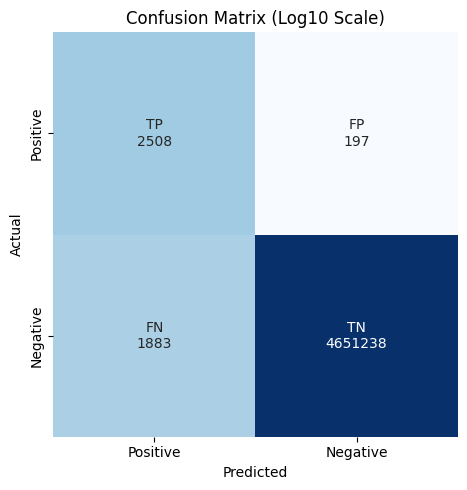

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,2508,197,1883,4651238,0.927172,0.571168,0.706877,0.999553


In [14]:
compute_metrics(geoGroundTruth, bertGeoClusters)

In [15]:
b3_metrics(geoGroundTruth, bertGeoClusters)

{'precision': 0.961762778505898,
 'recall': 0.6892201834862388,
 'f1_score': 0.8029959532377379}

In [16]:
pairwise_metrics(geoGroundTruth, bertGeoClusters)

{'TP': 2508,
 'FP': 197,
 'FN': 1883,
 'precision': 0.9271719038817006,
 'recall': 0.5711682987929857,
 'f1_score': 0.7068771138669674}

In [17]:
evaluate_log(geoGroundTruth, bertGeoClusters)

num of ground truth: 786
num of prediction: 993
[none] P=0.2427, R=0.3066, F1=0.2709
[pair] P=0.9272, R=0.5712, F1=0.7069


In [18]:
del bertGeoEm

### Sentence Bert - GPU

In [19]:
start = time.time()
bertGeoEm = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cuda', matcherType='knn', threshold=0.75, minLenghtToSubCluster=0, filterOversizedClusters=5)
bertGeoEm.configureKnn(1)
bertGeoClusters = bertGeoEm.pipeline()
end = time.time()
print('Sentence-Bert Geo run time:', end - start, 'seconds')

[07:41:11.11000]: Starting pipeline...
[07:41:11.11000]: Single table created with 3054 rows.
[07:41:11.11000]: Text column created.
Using device: cuda:0
[07:41:46.46000]: Embeddings created.
[07:41:46.46000]: Pairs created.
[07:41:46.46000]: Graph created. Creating clusters...
[07:41:46.46000]: Clusters created.
Sentence-Bert Geo run time: 35.51259088516235 seconds


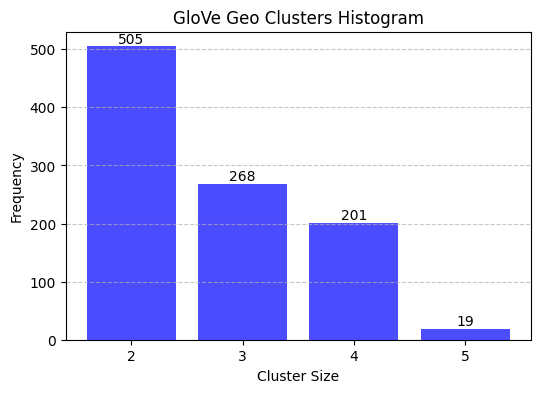

In [20]:
plot_histogram(histogram(bertGeoClusters), 'GloVe Geo Clusters Histogram', figsize=(6, 4))

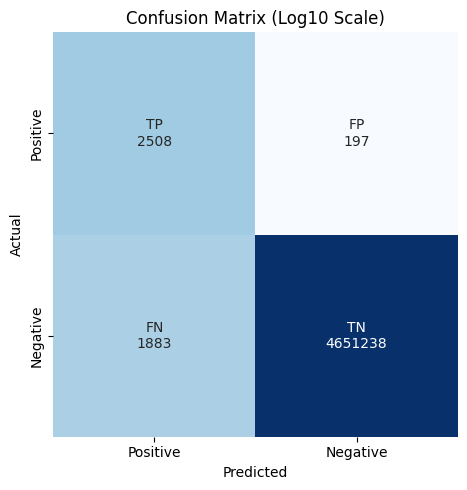

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,2508,197,1883,4651238,0.927172,0.571168,0.706877,0.999553


In [21]:
compute_metrics(geoGroundTruth, bertGeoClusters)

In [22]:
b3_metrics(geoGroundTruth, bertGeoClusters)

{'precision': 0.961762778505898,
 'recall': 0.6892201834862388,
 'f1_score': 0.8029959532377379}

In [23]:
pairwise_metrics(geoGroundTruth, bertGeoClusters)

{'TP': 2508,
 'FP': 197,
 'FN': 1883,
 'precision': 0.9271719038817006,
 'recall': 0.5711682987929857,
 'f1_score': 0.7068771138669674}

In [24]:
evaluate_log(geoGroundTruth, bertGeoClusters)

num of ground truth: 786
num of prediction: 993
[none] P=0.2427, R=0.3066, F1=0.2709
[pair] P=0.9272, R=0.5712, F1=0.7069


In [25]:
del bertGeoEm

## Music-20

**Global Variables**:

In [26]:
# global variables for Music-20 run
columns = {
  'title': 1,
  'artist': 1,
  'album': 1,
}
databasePath = './data/Music-20'
music20GroundTruth = get_ground_truth(databasePath)

### Glove

In [27]:
start = time.time()
gloveMusic20Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, gloveModelPath='./bin/glove.6B.300d.bin', minLenghtToSubCluster=0, filterOversizedClusters=5)
gloveMusic20Clusters = gloveMusic20Em.pipeline()
end = time.time()
print('GloVe Music-20 run time:', end - start, 'seconds')

[07:41:49.49000]: Starting pipeline...
[07:41:49.49000]: Single table created with 19375 rows.
[07:41:49.49000]: Text column created.
[07:41:52.52000]: Embeddings created.
[07:41:57.57000]: Pairs created.
[07:41:57.57000]: Graph created. Creating clusters...
[07:42:00.0]: Clusters created.
GloVe Music-20 run time: 11.063615560531616 seconds


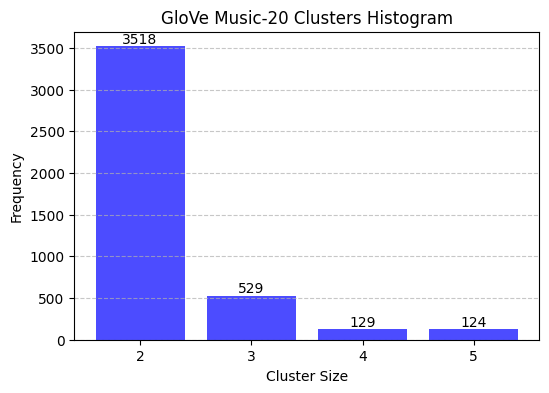

In [28]:
plot_histogram(histogram(gloveMusic20Clusters), 'GloVe Music-20 Clusters Histogram', figsize=(6, 4))

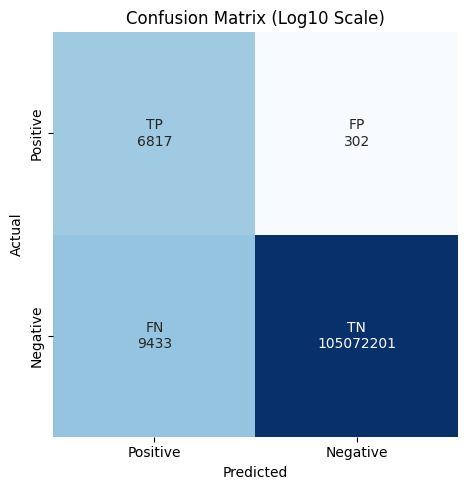

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,6817,302,9433,105072201,0.957578,0.419508,0.583422,0.999907


In [29]:
compute_metrics(music20GroundTruth, gloveMusic20Clusters)

In [30]:
b3_metrics(music20GroundTruth, gloveMusic20Clusters)

{'precision': 0.9861015312456891,
 'recall': 0.6404216673564049,
 'f1_score': 0.7765284717313902}

In [31]:
pairwise_metrics(music20GroundTruth, gloveMusic20Clusters)

{'TP': 6817,
 'FP': 302,
 'FN': 9433,
 'precision': 0.9575783115606125,
 'recall': 0.4195076923076923,
 'f1_score': 0.5834224827763276}

In [32]:
evaluate_log(music20GroundTruth, gloveMusic20Clusters)

num of ground truth: 5000
num of prediction: 4300
[none] P=0.4407, R=0.3790, F1=0.4075
[pair] P=0.9576, R=0.4195, F1=0.5834


In [33]:
del gloveMusic20Em

### Sentence Bert - CPU

In [34]:
start = time.time()
bertMusic20Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cpu', minLenghtToSubCluster=0, filterOversizedClusters=5)
bertMusic20Clusters = bertMusic20Em.pipeline()
end = time.time()
print('Sentence-Bert Music-20 run time:', end - start, 'seconds')

[07:42:05.5000]: Starting pipeline...
[07:42:05.5000]: Single table created with 19375 rows.
[07:42:05.5000]: Text column created.
Using device: cuda:0
[07:45:43.43000]: Embeddings created.
[07:45:46.46000]: Pairs created.
[07:45:46.46000]: Graph created. Creating clusters...
[07:45:48.48000]: Clusters created.
Sentence-Bert Music-20 run time: 223.38129544258118 seconds


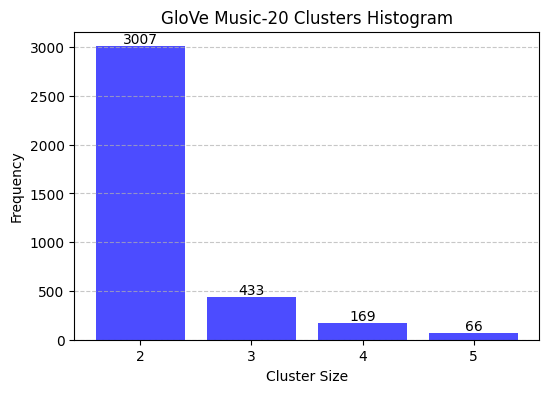

In [35]:
plot_histogram(histogram(bertMusic20Clusters), 'GloVe Music-20 Clusters Histogram', figsize=(6, 4))

In [36]:
pairwise_metrics(music20GroundTruth, bertMusic20Clusters)

{'TP': 5944,
 'FP': 36,
 'FN': 10306,
 'precision': 0.9939799331103679,
 'recall': 0.3657846153846154,
 'f1_score': 0.5347728295096715}

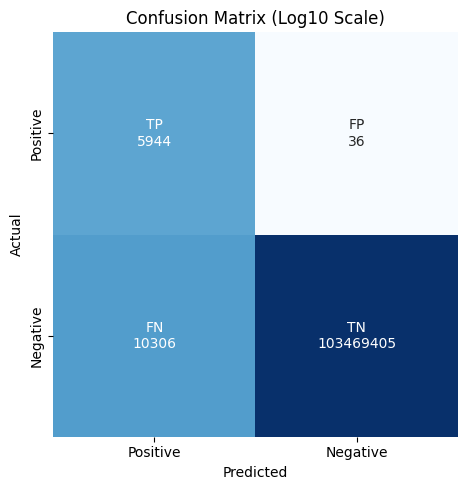

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,5944,36,10306,103469405,0.99398,0.365785,0.534773,0.9999


In [37]:
compute_metrics(music20GroundTruth, bertMusic20Clusters)

In [38]:
b3_metrics(music20GroundTruth, bertMusic20Clusters)

{'precision': 0.9982461018048705,
 'recall': 0.5980329464099331,
 'f1_score': 0.747969546016698}

In [39]:
evaluate_log(music20GroundTruth, bertMusic20Clusters)

num of ground truth: 5000
num of prediction: 3675
[none] P=0.4180, R=0.3072, F1=0.3541
[pair] P=0.9940, R=0.3658, F1=0.5348


In [40]:
del bertMusic20Em

### Sentence Bert - GPU

In [41]:
start = time.time()
bertMusic20Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cuda', minLenghtToSubCluster=0, filterOversizedClusters=5)
bertMusic20Clusters = bertMusic20Em.pipeline()
end = time.time()
print('Sentence-Bert Music-20 run time:', end - start, 'seconds')

[07:45:49.49000]: Starting pipeline...
[07:45:49.49000]: Single table created with 19375 rows.
[07:45:49.49000]: Text column created.
Using device: cuda:0
[07:49:27.27000]: Embeddings created.
[07:49:30.30000]: Pairs created.
[07:49:30.30000]: Graph created. Creating clusters...
[07:49:32.32000]: Clusters created.
Sentence-Bert Music-20 run time: 223.46605491638184 seconds


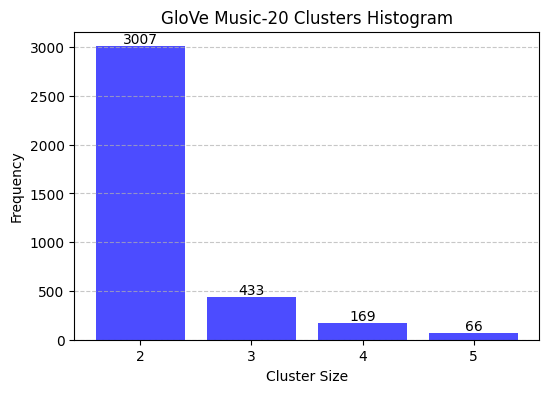

In [42]:
plot_histogram(histogram(bertMusic20Clusters), 'GloVe Music-20 Clusters Histogram', figsize=(6, 4))

In [43]:
pairwise_metrics(music20GroundTruth, bertMusic20Clusters)

{'TP': 5944,
 'FP': 36,
 'FN': 10306,
 'precision': 0.9939799331103679,
 'recall': 0.3657846153846154,
 'f1_score': 0.5347728295096715}

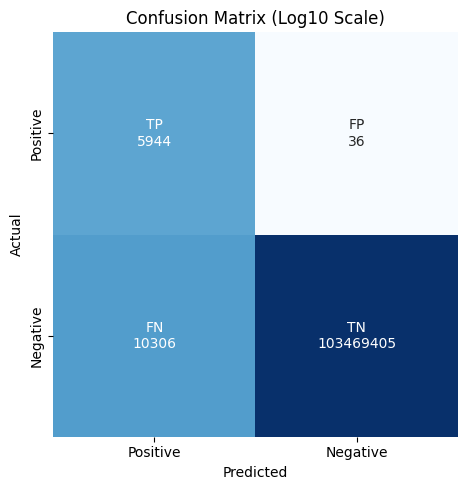

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,5944,36,10306,103469405,0.99398,0.365785,0.534773,0.9999


In [44]:
compute_metrics(music20GroundTruth, bertMusic20Clusters)

In [45]:
b3_metrics(music20GroundTruth, bertMusic20Clusters)

{'precision': 0.9982461018048705,
 'recall': 0.5980329464099331,
 'f1_score': 0.747969546016698}

In [46]:
evaluate_log(music20GroundTruth, bertMusic20Clusters)

num of ground truth: 5000
num of prediction: 3675
[none] P=0.4180, R=0.3072, F1=0.3541
[pair] P=0.9940, R=0.3658, F1=0.5348


In [47]:
del bertMusic20Em

## Music-200

**Global Variables**:

In [4]:
# global variables for Music-200 run
columns = {
  'title': 1,
  'artist': 1,
  'album': 1,
}
databasePath = './data/Music-200'
music200GroundTruth = get_ground_truth(databasePath)

### Glove

In [5]:
start = time.time()
gloveMusic200Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, gloveModelPath='./bin/glove.6B.300d.bin', matcherType='knn', threshold=0.9, minLenghtToSubCluster=0, filterOversizedClusters=5, runInLowMemory=False, batchSize=4096)
gloveMusic200Em.configureKnn(2)
gloveMusic200Clusters = gloveMusic200Em.pipeline()
end = time.time()
print('GloVe Music-200 run time:', end - start, 'seconds')

[00:08:48.48000]: Starting pipeline...
[00:08:49.49000]: Single table created with 193750 rows.
[00:08:50.50000]: Text column created. Creating embedder...
[00:09:04.4000]: Embeddings created. Creating matcher...
[00:13:23.23000]: Pairs created. Creating graph...
Creating graph with 387500 edges...
Found 193750 nodes.
Adding edges to graph...
[==================================================] 100.00%
[00:13:24.24000]: Graph created. Creating clusters...
[00:13:25.25000]: Clusters created.
GloVe Music-200 run time: 277.99329948425293 seconds


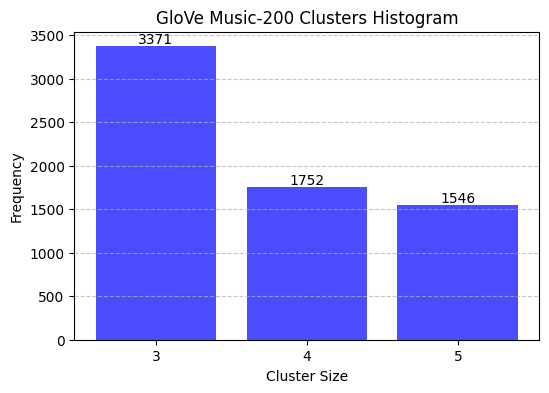

In [6]:
plot_histogram(histogram(gloveMusic200Clusters), 'GloVe Music-200 Clusters Histogram', figsize=(6, 4))

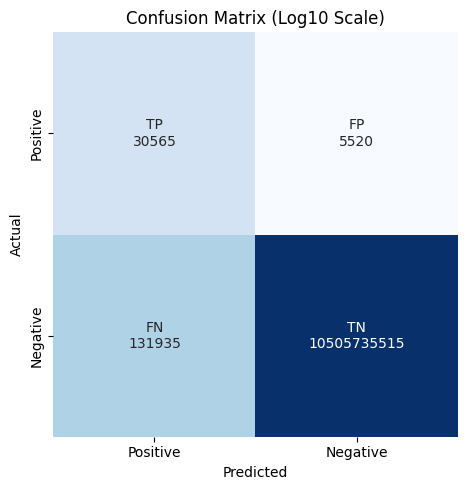

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,30565,5520,131935,10505735515,0.847028,0.188092,0.307828,0.999987


In [7]:
compute_metrics(music200GroundTruth, gloveMusic200Clusters)

In [8]:
b3_metrics(music200GroundTruth, gloveMusic200Clusters)

{'precision': 0.9817552573787304,
 'recall': 0.46299081324084373,
 'f1_score': 0.629236755525243}

In [9]:
pairwise_metrics(music200GroundTruth, gloveMusic200Clusters)

{'TP': 30565,
 'FP': 5520,
 'FN': 131935,
 'precision': 0.8470278509075794,
 'recall': 0.1880923076923077,
 'f1_score': 0.3078278822670393}

In [10]:
evaluate_log(music200GroundTruth, gloveMusic200Clusters)

num of ground truth: 50000
num of prediction: 6669
[none] P=0.7126, R=0.0950, F1=0.1677
[pair] P=0.8470, R=0.1881, F1=0.3078


In [11]:
del gloveMusic200Em

### Sentence Bert - CPU

In [13]:
start = time.time()
bertMusic200Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cpu', matcherType='knn', minLenghtToSubCluster=0, filterOversizedClusters=5, runInLowMemory=False, batchSize=4096)
bertMusic200Em.configureKnn(2)
bertMusic200Clusters = bertMusic200Em.pipeline()
end = time.time()
print('Sentence-Bert Music-200 run time:', end - start, 'seconds')

[19:06:06.6000]: Starting pipeline...
[19:06:07.7000]: Single table created with 193750 rows.
[19:06:07.7000]: Text column created. Creating embedder...
Using device: cuda:0
[19:44:07.7000]: Embeddings created. Creating matcher...
[19:48:23.23000]: Pairs created. Creating graph...
Creating graph with 387500 edges...
Found 193750 nodes.
Adding edges to graph...
[==================================================] 100.00%
[19:48:24.24000]: Graph created. Creating clusters...
[19:48:25.25000]: Clusters created.
Sentence-Bert Music-200 run time: 2539.172082901001 seconds


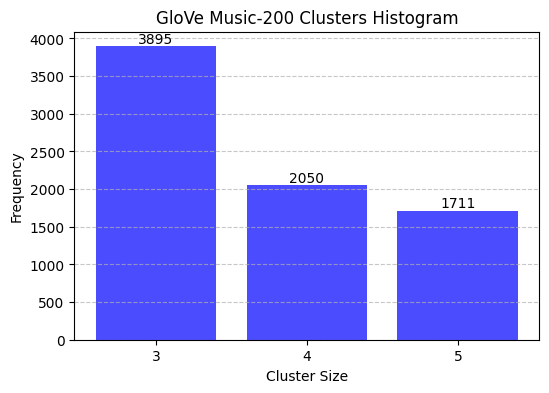

In [14]:
plot_histogram(histogram(bertMusic200Clusters), 'GloVe Music-200 Clusters Histogram', figsize=(6, 4))

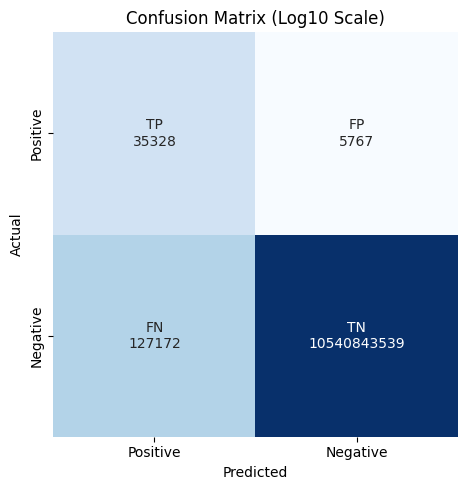

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,35328,5767,127172,10540843539,0.859667,0.217403,0.347042,0.999987


In [15]:
compute_metrics(music200GroundTruth, bertMusic200Clusters)

In [16]:
b3_metrics(music200GroundTruth, bertMusic200Clusters)

{'precision': 0.9809681559077318,
 'recall': 0.4839544435030808,
 'f1_score': 0.6481487802529776}

In [17]:
pairwise_metrics(music200GroundTruth, bertMusic200Clusters)

{'TP': 35328,
 'FP': 5767,
 'FN': 127172,
 'precision': 0.8596666261102324,
 'recall': 0.21740307692307692,
 'f1_score': 0.3470419214617255}

In [18]:
evaluate_log(music200GroundTruth, bertMusic200Clusters)

num of ground truth: 50000
num of prediction: 7656
[none] P=0.7670, R=0.1174, F1=0.2037
[pair] P=0.8597, R=0.2174, F1=0.3470


In [19]:
del bertMusic200Em

### Sentence Bert - GPU

In [26]:
start = time.time()
bertMusic200Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cuda', matcherType='knn', minLenghtToSubCluster=0, filterOversizedClusters=5, runInLowMemory=False, batchSize=4096)
bertMusic200Em.configureKnn(2)
bertMusic200Clusters = bertMusic200Em.pipeline()
end = time.time()
print('Sentence-Bert Music-200 run time:', end - start, 'seconds')

[21:51:12.12000]: Starting pipeline...
[21:51:13.13000]: Single table created with 193750 rows.
[21:51:14.14000]: Text column created. Creating embedder...
Using device: cuda:0
[22:34:27.27000]: Embeddings created. Creating matcher...
[22:40:20.20000]: Pairs created. Creating graph...
Creating graph with 387500 edges...
Found 193750 nodes.
Adding edges to graph...
[==================================================] 100.00%
[22:40:22.22000]: Graph created. Creating clusters...
[22:40:23.23000]: Clusters created.
Sentence-Bert Music-200 run time: 2951.382705450058 seconds


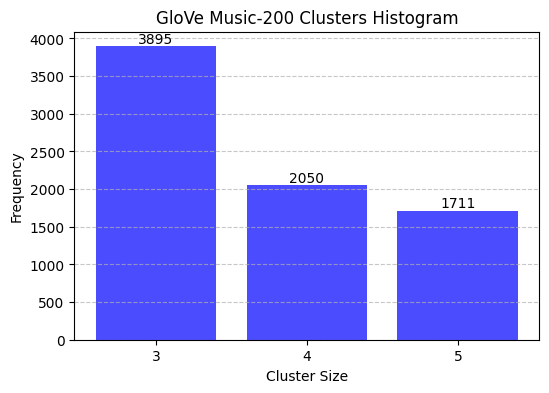

In [33]:
plot_histogram(histogram(bertMusic200Clusters), 'GloVe Music-200 Clusters Histogram', figsize=(6, 4))

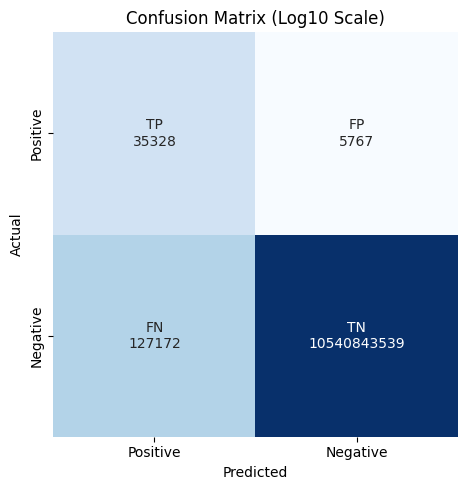

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,35328,5767,127172,10540843539,0.859667,0.217403,0.347042,0.999987


In [34]:
compute_metrics(music200GroundTruth, bertMusic200Clusters)

In [35]:
b3_metrics(music200GroundTruth, bertMusic200Clusters)

{'precision': 0.9809681559077318,
 'recall': 0.4839544435030808,
 'f1_score': 0.6481487802529776}

In [36]:
pairwise_metrics(music200GroundTruth, bertMusic200Clusters)

{'TP': 35328,
 'FP': 5767,
 'FN': 127172,
 'precision': 0.8596666261102324,
 'recall': 0.21740307692307692,
 'f1_score': 0.3470419214617255}

In [37]:
evaluate_log(music200GroundTruth, bertMusic200Clusters)

num of ground truth: 50000
num of prediction: 7656
[none] P=0.7670, R=0.1174, F1=0.2037
[pair] P=0.8597, R=0.2174, F1=0.3470


In [ ]:
del bertMusic200Em

## Music-2000

**Global Variables**:

In [4]:
# global variables for Music-2000 run
columns = {
  'title': 1,
  'artist': 1,
  'album': 1,
}
databasePath = './data/Music-2000'
music2000GroundTruth = get_ground_truth(databasePath)

### Glove

In [5]:
start = time.time()
gloveMusic2000Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, gloveModelPath='./bin/glove.6B.300d.bin', matcherType='knn', minLenghtToSubCluster=0, filterOversizedClusters=5, runInLowMemory=False, batchSize=8192)
gloveMusic2000Em.configureKnn(2)
gloveMusic2000Clusters = gloveMusic2000Em.pipeline()
end = time.time()
print('GloVe Music-2000 run time:', end - start, 'seconds')

[01:29:35.35000]: Starting pipeline...
[01:29:40.40000]: Single table created with 1937500 rows.
[01:29:48.48000]: Text column created. Creating embedder...
[01:30:53.53000]: Embeddings created. Creating matcher...
[05:47:26.26000]: Pairs created. Creating graph...
Creating graph with 3875000 edges...
Found 1937500 nodes.
Adding edges to graph...
[==================================================] 100.00%
[05:47:36.36000]: Graph created. Creating clusters...
[05:48:02.2000]: Clusters created.
GloVe Music-2000 run time: 15510.095720529556 seconds


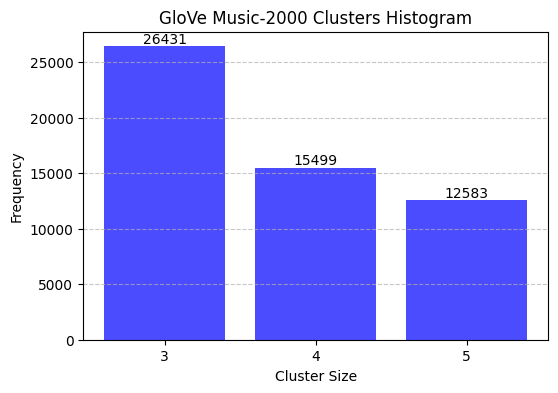

In [6]:
plot_histogram(histogram(gloveMusic2000Clusters), 'GloVe Music-2000 Clusters Histogram', figsize=(6, 4))

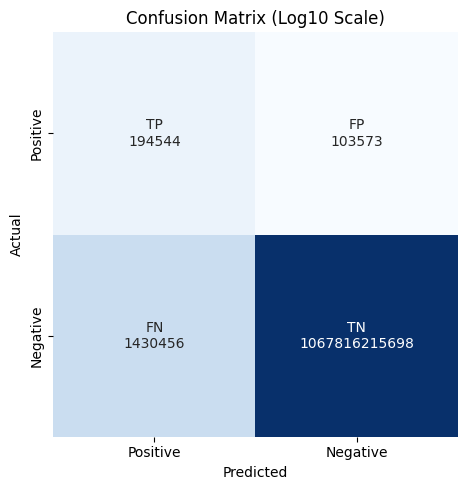

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,194544,103573,1430456,1067816215698,0.652576,0.119719,0.202322,0.999999


In [7]:
compute_metrics(music2000GroundTruth, gloveMusic2000Clusters)

In [8]:
b3_metrics(music2000GroundTruth, gloveMusic2000Clusters)

{'precision': 0.9653373769943098,
 'recall': 0.4311800291320279,
 'f1_score': 0.5961031298409563}

In [9]:
pairwise_metrics(music2000GroundTruth, gloveMusic2000Clusters)

{'TP': 194544,
 'FP': 103573,
 'FN': 1430456,
 'precision': 0.6525760020394678,
 'recall': 0.11971938461538462,
 'f1_score': 0.20232154361903099}

In [10]:
evaluate_log(music2000GroundTruth, gloveMusic2000Clusters)

num of ground truth: 500000
num of prediction: 54513
[none] P=0.4583, R=0.0500, F1=0.0901
[pair] P=0.6526, R=0.1197, F1=0.2023


In [11]:
del gloveMusic2000Em

### Sentence Bert - CPU

In [12]:
start = time.time()
bertMusic2000Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cpu', minLenghtToSubCluster=0, filterOversizedClusters=5, runInLowMemory=False, batchSize=1500)
bertMusic2000Em.configureKnn(2)
bertMusic2000Clusters = bertMusic2000Em.pipeline()
end = time.time()
print('Sentence-Bert Music-2000 run time:', end - start, 'seconds')

[05:48:17.17000]: Starting pipeline...
[05:48:21.21000]: Single table created with 1937500 rows.
[05:48:29.29000]: Text column created. Creating embedder...
Using device: cuda:0
[11:40:11.11000]: Embeddings created. Creating matcher...


MemoryError: Unable to allocate 13.7 TiB for an array with shape (1937500, 1937500) and data type float32

In [ ]:
plot_histogram(histogram(bertMusic2000Clusters), 'GloVe Music-2000 Clusters Histogram', figsize=(6, 4))

In [ ]:
compute_metrics(music2000GroundTruth, bertMusic2000Clusters)

In [ ]:
b3_metrics(music2000GroundTruth, bertMusic2000Clusters)

In [ ]:
pairwise_metrics(music2000GroundTruth, bertMusic2000Clusters)

In [ ]:
evaluate_log(music2000GroundTruth, bertMusic2000Clusters)

In [ ]:
del bertMusic2000Em

### Sentence Bert - GPU

In [ ]:
start = time.time()
bertMusic2000Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cuda', minLenghtToSubCluster=0, filterOversizedClusters=5, runInLowMemory=False, batchSize=4096)
bertMusic2000Em.configureKnn(2)
bertMusic2000Clusters = bertMusic2000Em.pipeline()
end = time.time()
print('Sentence-Bert Music-2000 run time:', end - start, 'seconds')

In [ ]:
plot_histogram(histogram(bertMusic2000Clusters), 'GloVe Music-2000 Clusters Histogram', figsize=(6, 4))

In [ ]:
compute_metrics(music2000GroundTruth, bertMusic2000Clusters)

In [ ]:
b3_metrics(music2000GroundTruth, bertMusic2000Clusters)

In [ ]:
pairwise_metrics(music2000GroundTruth, bertMusic2000Clusters)

In [ ]:
evaluate_log(music2000GroundTruth, bertMusic2000Clusters)

In [ ]:
del bertMusic2000Em

### GloVe com cosine

In [ ]:
start = time.time()
gloveMusic2000Em = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, gloveModelPath='./bin/glove.6B.300d.bin', matcherType='cosine', minLenghtToSubCluster=0, filterOversizedClusters=5, runInLowMemory=True, batchSize=16384*2)
gloveMusic2000Clusters = gloveMusic2000Em.pipeline()
end = time.time()
print('GloVe Music-2000 run time:', end - start, 'seconds')

[19:48:47.47000]: Starting pipeline...
[19:48:50.50000]: Single table created with 1937500 rows.
[19:48:59.59000]: Text column created. Creating embedder...
[19:50:17.17000]: Embeddings created. Creating matcher...
[==================================================] 100.00%
[00:12:25.25000]: Pairs created. Creating graph...
Creating graph with 149237850 edges...
Found 1380352 nodes.
Adding edges to graph...
[==========================-----------------------] 52.58%

## Shopee

**Global Variables**:

In [4]:
# global variables for Shopee run
columns = {
  'title': 1,
}
databasePath = './data/Shopee'
shopeeGroundTruth = get_ground_truth(databasePath)

### Glove

In [15]:
start = time.time()
gloveShopeeEm = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, matcherType='cosine', gloveModelPath='./bin/glove.6B.300d.bin', minLenghtToSubCluster=0, filterOversizedClusters=5)
gloveShopeeClusters = gloveShopeeEm.pipeline()
end = time.time()
print('GloVe Shopee run time:', end - start, 'seconds')

[00:43:31.31000]: Starting pipeline...
[00:43:31.31000]: Single table created with 32563 rows.
[00:43:31.31000]: Text column created. Creating embedder...
[00:43:34.34000]: Embeddings created. Creating matcher...
[00:43:53.53000]: Pairs created. Creating graph...
Creating graph with 31360 edges...
Found 11654 nodes.
Adding edges to graph...
[=================================================] 99.81%
[00:43:53.53000]: Graph created. Creating clusters...
[00:43:56.56000]: Clusters created.
GloVe Shopee run time: 25.31761384010315 seconds


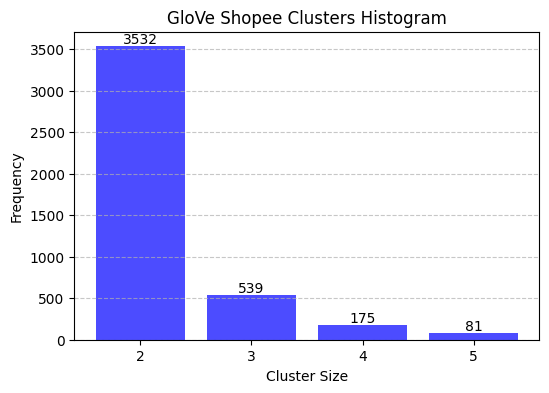

In [16]:
plot_histogram(histogram(gloveShopeeClusters), 'GloVe Shopee Clusters Histogram', figsize=(6, 4))

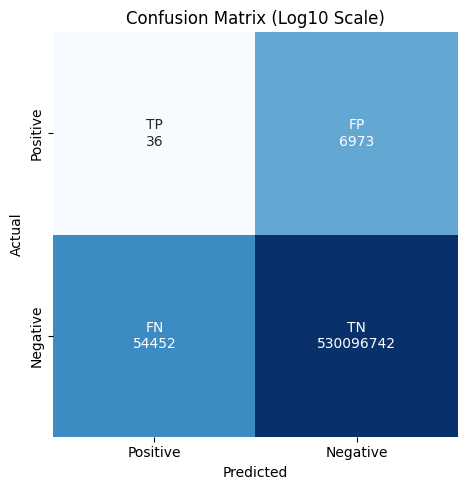

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,36,6973,54452,530096742,0.005136,0.000661,0.001171,0.999884


In [17]:
compute_metrics(shopeeGroundTruth, gloveShopeeClusters)

In [18]:
b3_metrics(shopeeGroundTruth, gloveShopeeClusters)

{'precision': 0.8332811268412927,
 'recall': 0.33716029080402077,
 'f1_score': 0.4800741033455982}

In [19]:
pairwise_metrics(shopeeGroundTruth, gloveShopeeClusters)

{'TP': 36,
 'FP': 6973,
 'FN': 54452,
 'precision': 0.0051362533885004995,
 'recall': 0.0006606959330494788,
 'f1_score': 0.0011707888189667788}

In [20]:
evaluate_log(shopeeGroundTruth, gloveShopeeClusters)

num of ground truth: 10962
num of prediction: 4327
[none] P=0.0007, R=0.0003, F1=0.0004
[pair] P=0.0051, R=0.0007, F1=0.0012


In [21]:
del gloveShopeeEm

### Sentence Bert - CPU

In [5]:
start = time.time()
bertShopeeEm = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cpu', minLenghtToSubCluster=0, filterOversizedClusters=5)
bertShopeeClusters = bertShopeeEm.pipeline()
end = time.time()
print('Sentence-Bert Shopee run time:', end - start, 'seconds')

[00:47:08.8000]: Starting pipeline...
[00:47:09.9000]: Single table created with 32563 rows.
[00:47:09.9000]: Text column created. Creating embedder...
Using device: cuda:0
[00:53:26.26000]: Embeddings created. Creating matcher...
[00:53:38.38000]: Pairs created. Creating graph...
Creating graph with 21118 edges...
Found 10544 nodes.
Adding edges to graph...
[=================================================] 99.91%
[00:53:38.38000]: Graph created. Creating clusters...
[00:53:38.38000]: Clusters created.
Sentence-Bert Shopee run time: 389.69651460647583 seconds


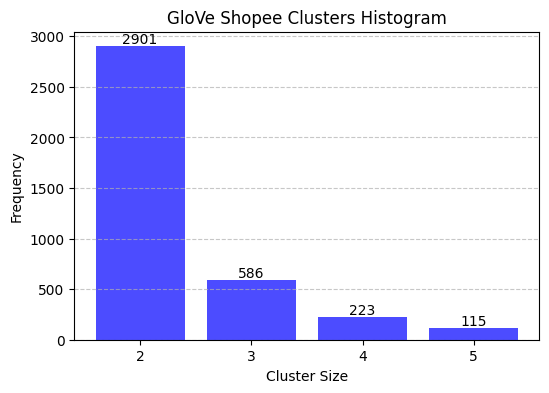

In [6]:
plot_histogram(histogram(bertShopeeClusters), 'GloVe Shopee Clusters Histogram', figsize=(6, 4))

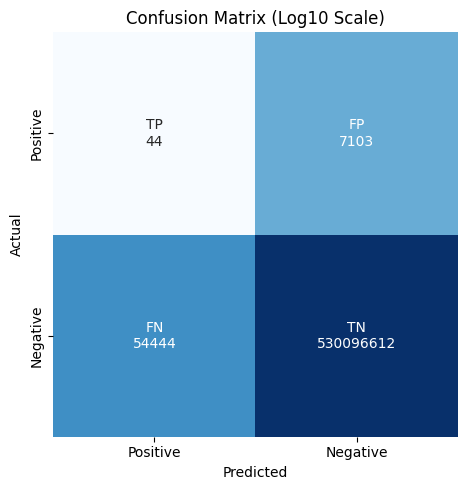

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,44,7103,54444,530096612,0.006156,0.000808,0.001428,0.999884


In [7]:
compute_metrics(shopeeGroundTruth, bertShopeeClusters)

In [8]:
b3_metrics(shopeeGroundTruth, bertShopeeClusters)

{'precision': 0.8411960404958496,
 'recall': 0.33724242283241634,
 'f1_score': 0.48146254488781376}

In [9]:
pairwise_metrics(shopeeGroundTruth, bertShopeeClusters)

{'TP': 44,
 'FP': 7103,
 'FN': 54444,
 'precision': 0.006156429271022806,
 'recall': 0.0008075172515049186,
 'f1_score': 0.001427760201184392}

In [10]:
evaluate_log(shopeeGroundTruth, bertShopeeClusters)

num of ground truth: 10962
num of prediction: 3825
[none] P=0.0008, R=0.0003, F1=0.0004
[pair] P=0.0062, R=0.0008, F1=0.0014


In [11]:
del bertShopeeEm

### Sentence Bert - GPU

In [12]:
start = time.time()
bertShopeeEm = lightem.EntityMatcher(databasePath=databasePath, columnsToText=columns, embedderType='sentence-transformers', sentenceBertDevice='cpu', minLenghtToSubCluster=0, filterOversizedClusters=5)
bertShopeeClusters = bertShopeeEm.pipeline()
end = time.time()
print('Sentence-Bert Shopee run time:', end - start, 'seconds')

[00:53:39.39000]: Starting pipeline...
[00:53:39.39000]: Single table created with 32563 rows.
[00:53:39.39000]: Text column created. Creating embedder...
Using device: cuda:0
[00:59:57.57000]: Embeddings created. Creating matcher...
[01:00:08.8000]: Pairs created. Creating graph...
Creating graph with 21118 edges...
Found 10544 nodes.
Adding edges to graph...
[=================================================] 99.91%
[01:00:08.8000]: Graph created. Creating clusters...
[01:00:08.8000]: Clusters created.
Sentence-Bert Shopee run time: 389.6329777240753 seconds


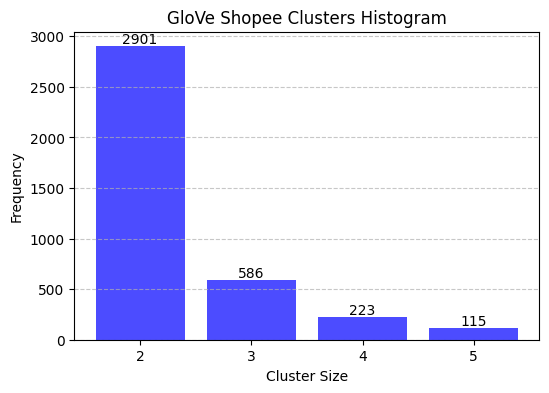

In [13]:
plot_histogram(histogram(bertShopeeClusters), 'GloVe Shopee Clusters Histogram', figsize=(6, 4))

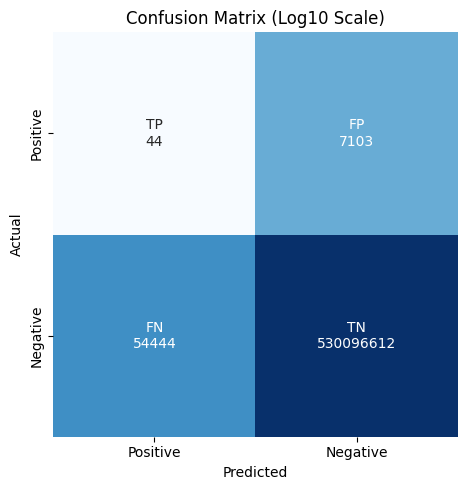

,TP,FP,FN,TN,Precision,Recall,F1 Score,Accuracy
0,44,7103,54444,530096612,0.006156,0.000808,0.001428,0.999884


In [14]:
compute_metrics(shopeeGroundTruth, bertShopeeClusters)

In [15]:
b3_metrics(shopeeGroundTruth, bertShopeeClusters)

{'precision': 0.8411960404958496,
 'recall': 0.33724242283241634,
 'f1_score': 0.48146254488781376}

In [16]:
pairwise_metrics(shopeeGroundTruth, bertShopeeClusters)

{'TP': 44,
 'FP': 7103,
 'FN': 54444,
 'precision': 0.006156429271022806,
 'recall': 0.0008075172515049186,
 'f1_score': 0.001427760201184392}

In [17]:
evaluate_log(shopeeGroundTruth, bertShopeeClusters)

num of ground truth: 10962
num of prediction: 3825
[none] P=0.0008, R=0.0003, F1=0.0004
[pair] P=0.0062, R=0.0008, F1=0.0014


In [18]:
del bertShopeeEm